In [ ]:
import sys
import os

notebook_path = os.getcwd() 
parent_dir = os.path.dirname(notebook_path)
project_root = os.path.dirname(parent_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
import state_NN_models
import Filters
import utils
import Systems
from utils import losses, trainer, utils
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
state_dim_2d = 2
obs_dim_2d = 2

F_base_2d = torch.tensor([[1.0, 1.0], 
                          [0.0, 1.0]])

svd_F = torch.linalg.svd(F_base_2d)
F_true_2d = F_base_2d / svd_F.S[0]
print(F_true_2d)

H_true_2d = torch.eye(obs_dim_2d)

Q_true_2d = torch.eye(state_dim_2d) * 0.5 # Šum procesu
R_true_2d = torch.eye(obs_dim_2d) * 0.1 # Šum měření

# Počáteční podmínky
Ex0_true_2d = torch.tensor([[1.0], [0.0]])
P0_true_2d = torch.eye(state_dim_2d) * 1.5
F_model_2d = F_true_2d
H_model_2d = H_true_2d
Q_model_2d = torch.eye(state_dim_2d) * 0.1
R_model_2d = R_true_2d
Ex0_model_2d = torch.tensor([[0.5], [0.5]])
P0_model_2d = torch.eye(state_dim_2d) * 1.0

print("\nInicializuji 2D Linear_Canonical systém (replikace autorů)...")
sys_true = Systems.DynamicSystem(
    state_dim=state_dim_2d, obs_dim=obs_dim_2d,
    Ex0=Ex0_true_2d, P0=P0_true_2d,
    Q=Q_true_2d, R=R_true_2d,
    F=F_true_2d, H=H_true_2d,
    device=device
)
sys_model = Systems.DynamicSystem(
    state_dim=state_dim_2d, obs_dim=obs_dim_2d,
    Ex0=Ex0_model_2d, P0=P0_model_2d,
    Q=Q_model_2d, R=R_model_2d,
    F=F_model_2d, H=H_model_2d,
    device=device
)
print("... 2D systém inicializován.")

tensor([[0.6180, 0.6180],
        [0.0000, 0.6180]])

Inicializuji 2D Linear_Canonical systém (replikace autorů)...
... 2D systém inicializován.


In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 100      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 8         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy

model_config = {
    "hidden_size_multiplier": 10,
    "output_layer_multiplier": 4,
    "num_gru_layers": 1,
    "init_min_dropout": 0.5,
    "init_max_dropout": 0.8
}

train_config = {
    "total_train_iter": 1200,
    "learning_rate": 1e-4,
    "clip_grad": 10.0,
    "J_samples": 20,
    "validation_period": 20,
    "logging_period": 20,
    "warmup_iterations": 100 # Trénuj prvních 100 iterací jen na MSE
}

# =================================================================================
# KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU NEBO NAČTENÍ HOTOVÉHO MODELU
# =================================================================================

print("="*80)
print("Připravuji Bayesian KalmanNet (BKN)...")
print(f"Parametry modelu: {model_config}")
print(f"Parametry tréninku: {train_config}")
print("="*80)

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Definice cesty ke složce a souboru
save_dir = "LinearSystemWeights"
os.makedirs(save_dir, exist_ok=True)
weights_path = os.path.join(save_dir, "best_bkn_model_weights.pth")

# Vytvoření modelu (potřebujeme ho inicializovat v obou případech)
state_bkn_knet = StateBayesianKalmanNet(
    sys_model,
    device=device,
    **model_config
).to(device)

# Podmínka pro načtení nebo trénink
if os.path.exists(weights_path):
    print(f"\nINFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah
    state_bkn_knet.load_state_dict(torch.load(weights_path, map_location=device))
    trained_model = state_bkn_knet
    
else:
    print("\nINFO: Váhy nebyly nalezeny. Spouštím plnohodnotný tréninkový běh...")
    
    # Spuštění tréninku
    results = trainer.training_session_trajectory_with_gaussian_nll_training_fcn(
        model=state_bkn_knet,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        **train_config
    )

    # `run_training_session` automaticky načte nejlepší model zpět,
    # takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
    trained_model = results['final_model']
    
    # Uložení vah pro příští použití
    torch.save(trained_model.state_dict(), weights_path)
    print(f"\nINFO: Váhy modelu byly úspěšně uloženy do: {weights_path}")

    # Výpis metrik pouze pokud jsme trénovali
    print("\n" + "="*80)
    print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z NEJLEPŠÍHO MODELU")
    print("="*80)
    print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
    print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
    print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
    print(f"  MSE na validační sadě:       {results['best_val_mse']:.4f}")
    print(f"  NLL na validační sadě:       {results['best_val_nll']:.4f}")
    print("="*80)

# Prepnutí do evaluačního módu na konci bloku (klíčové pro BKN kvůli Dropoutu)
trained_model.eval()
print("\nModel BKN je plně připraven v proměnné 'trained_model'.")

Připravuji Bayesian KalmanNet (BKN)...
Parametry modelu: {'hidden_size_multiplier': 10, 'output_layer_multiplier': 4, 'num_gru_layers': 1, 'init_min_dropout': 0.5, 'init_max_dropout': 0.8}
Parametry tréninku: {'total_train_iter': 1200, 'learning_rate': 0.0001, 'clip_grad': 10.0, 'J_samples': 20, 'validation_period': 20, 'logging_period': 20, 'warmup_iterations': 100}
INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva vynulována (Soft Start).

INFO: Uložené váhy nalezeny v 'LinearSystemWeights/best_bkn_model_weights.pth'.
Přeskakuji trénink a načítám hotový model...

Model BKN je plně připraven v proměnné 'trained_model'.


In [8]:
# import os
# import torch

# # =================================================================================
# # KROK 4: ULOŽENÍ A OPĚTOVNÉ NAČTENÍ VAH MODELU
# # =================================================================================

# # 1. Vytvoření cílové složky (pokud ještě neexistuje)
# save_dir = "LinearSystemWeights"
# os.makedirs(save_dir, exist_ok=True)

# # Cesta k souboru s váhami
# weights_path = os.path.join(save_dir, "best_bkn_model_weights.pth")

# # 2. Uložení vah aktuálně nejlepšího modelu z předchozí buňky
# torch.save(trained_model.state_dict(), weights_path)
# print(f"Váhy modelu byly úspěšně uloženy do: {weights_path}")

# # 3. Následné načtení modelu z uložených vah
# print("Načítám váhy zpět do nové instance modelu...")

# # Nejprve musíme vytvořit novou, prázdnou instanci modelu se naprosto stejnou konfigurací
# loaded_bkn_model = StateBayesianKalmanNet(
#     sys_model,
#     device=device,
#     **model_config
# ).to(device)

# # Načteme uložený slovník vah do této nové instance
# loaded_bkn_model.load_state_dict(torch.load(weights_path))

# # Přepneme model do evaluačního módu (velmi důležité pro dropout a batchnorm vrstvy před testováním!)
# loaded_bkn_model.eval()

# # Přiřadíme do proměnné trained_model, jak jsi požadoval
# trained_model = loaded_bkn_model

# print("Model byl úspěšně načten a je připraven v proměnné 'trained_model' k vyhodnocení.")

In [9]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

save_dir = "LinearSystemWeights"
weights_path = os.path.join(save_dir, "best_knet_model_weights.pth")

# Vytvoření cílové složky (pokud ještě neexistuje, nic se nestane)
os.makedirs(save_dir, exist_ok=True)


state_knetR = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=12,returns_covariance=True).to(device)

if os.path.exists(weights_path):
    print(f"INFO: Uložené váhy nalezeny v '{weights_path}'.")
    print("Přeskakuji trénink a načítám hotový model...")
    
    # Načtení vah (map_location zajistí kompatibilitu, pokud bys např. trénoval na GPU a načítal na CPU)
    state_knetR.load_state_dict(torch.load(weights_path, map_location=device))
    
else:
    print("INFO: Váhy nebyly nalezeny. Spouštím trénink modelu...")
    
    # Spuštění tréninku
    trainer.train_state_KalmanNet(
        model=state_knetR, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        device=device, 
        epochs=100, 
        lr=1e-4,
        early_stopping_patience=30
    )
    
    # Po úspěšném tréninku váhy rovnou uložíme pro příští spuštění
    torch.save(state_knetR.state_dict(), weights_path)
    print(f"Trénink dokončen. Váhy byly bezpečně uloženy do '{weights_path}'.")

# Prepnutí do evaluačního módu (dobrá praxe před testováním)
state_knetR.eval()

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
INFO: Uložené váhy nalezeny v 'LinearSystemWeights/best_knet_model_weights.pth'.
Přeskakuji trénink a načítám hotový model...


StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Sequential(
      (0): Linear(in_features=8, out_features=384, bias=True)
      (1): ReLU()
    )
    (gru): GRU(384, 8)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)

In [10]:
# import os
# import torch

# # =================================================================================
# # KROK 4: ULOŽENÍ A OPĚTOVNÉ NAČTENÍ VAH MODELU
# # =================================================================================

# # 1. Vytvoření cílové složky (pokud ještě neexistuje)
# save_dir = "LinearSystemWeights"
# os.makedirs(save_dir, exist_ok=True)

# # Cesta k souboru s váhami
# weights_path = os.path.join(save_dir, "best_knet_model_weights.pth")

# # 2. Uložení vah aktuálně nejlepšího modelu z předchozí buňky
# torch.save(trained_model.state_dict(), weights_path)
# print(f"Váhy modelu byly úspěšně uloženy do: {weights_path}")

# # 3. Následné načtení modelu z uložených vah
# print("Načítám váhy zpět do nové instance modelu...")

# # Nejprve musíme vytvořit novou, prázdnou instanci modelu se naprosto stejnou konfigurací
# loaded_knet_model = StateKalmanNetWithKnownR(
#     sys_model,
#     device=device, hidden_size_multiplier=12
# ).to(device)

# # Načteme uložený slovník vah do této nové instance
# loaded_knet_model.load_state_dict(torch.load(weights_path))

# # Přepneme model do evaluačního módu (velmi důležité pro dropout a batchnorm vrstvy před testováním!)
# loaded_knet_model.eval()

# # Přiřadíme do proměnné trained_model, jak jsi požadoval
# state_knetR = loaded_knet_model

# print("Model byl úspěšně načten a je připraven v proměnné 'state_knetR' k vyhodnocení.")

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import Filters
# ==============================================================================
# 0. PŘEDPOKLADY - ZDE PŘIŘAĎTE VAŠE NATRÉNOVANÉ MODELY
# ==============================================================================
# Ujistěte se, že v proměnných níže máte již natrénované a připravené modely.
# Názvy proměnných si upravte podle vašeho kódu, pokud se liší.
try:
    trained_model_bkn = trained_model
    trained_model_knetR = state_knetR
    print("INFO: Všechny natrénované modely nalezeny a přiřazeny.")
except NameError:
    print("VAROVÁNÍ: Některé z proměnných `trained_model`, `state_knet`, nebo `state_knetR` nebyly nalezeny.")
    print("         Ujistěte se, že jste nejprve úspěšně dokončili trénink všech modelů.")


# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 10000
NUM_TEST_TRAJ = 1
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

# ==============================================================================
# 3. INICIALIZACE VŠECH FILTRŮ PRO POROVNÁNÍ
# ==============================================================================
ekf_mismatched = Filters.ExtendedKalmanFilter(sys_model)
ekf_ideal = Filters.ExtendedKalmanFilter(sys_true)
ukf_mismatched = Filters.UnscentedKalmanFilter(sys_model)
ukf_ideal = Filters.UnscentedKalmanFilter(sys_true)
akf_mismatched = Filters.AdaptiveKalmanFilter_default(sys_model,mdm_L=3,mdm_version=2,lambda_rls=1.0,init_sigma_rls_value=0.1)
akf_mehra_mismatched = Filters.AdaptiveKalmanFilter_mehra_offline(sys_model,num_iterations=5)
kf_ideal = Filters.KalmanFilter(sys_true)
print("Všechny model-based filtry (EKF, UKF, AKF) inicializovány.")

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Seznamy pro ukládání výsledků z každé trajektorie
all_x_true_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []
all_x_hat_knetR_cpu, all_P_hat_knetR_cpu = [], []
all_x_hat_ekf_mismatched_cpu, all_P_hat_ekf_mismatched_cpu = [], []
all_x_hat_ekf_ideal_cpu, all_P_hat_ekf_ideal_cpu = [], []
all_x_hat_ukf_mismatched_cpu, all_P_hat_ukf_mismatched_cpu = [], []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_akf_mismatched_cpu, all_P_hat_akf_mismatched_cpu = [], []
all_x_hat_kf_ideal_cpu, all_P_hat_kf_ideal_cpu = [], []
all_x_hat_akf_mehra_mismatched_cpu, all_P_hat_akf_mehra_mismatched_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

trained_model_bkn.eval() 
trained_model_knetR.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        

                # --- F. Adaptivní KF (nepřesný) --- 
        akf_mehra_m_res = akf_mehra_mismatched.process_sequence(y_test_seq_gpu)
        x_hat_mehra_seq = akf_mehra_m_res['x_filtered']   
        full_x_hat_akf_mehra_m = x_hat_mehra_seq
        # full_x_hat_akf_mehra_m = torch.cat([initial_state, x_hat_mehra_seq], dim=0)



        # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        ensemble_trajectories = []
        for j in range(J_SAMPLES_TEST):
            trained_model_bkn.reset(batch_size=1, initial_state=initial_state)
            current_x_hats = []
            for t in range(1, TEST_SEQ_LEN):
                x_filtered_t, _ = trained_model_bkn.step(y_test_seq_gpu[t, :].unsqueeze(0))
                current_x_hats.append(x_filtered_t)
            ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        ensemble = torch.stack(ensemble_trajectories, dim=0)
        predictions_bkn = ensemble.mean(dim=0)
        diff = ensemble - predictions_bkn.unsqueeze(0)
        covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        full_P_hat_bkn = torch.cat([sys_model.P0.unsqueeze(0), covariances_bkn], dim=0)

        # --- C. StateKalmanNetWithKnownR ---
        trained_model_knetR.reset(batch_size=1, initial_state=initial_state)
        knetR_preds_x, knetR_preds_P = [], []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t, P_filtered_t = trained_model_knetR.step(y_test_seq_gpu[t, :].unsqueeze(0))
            knetR_preds_x.append(x_filtered_t)
            knetR_preds_P.append(P_filtered_t)
        full_x_hat_knetR = torch.cat([initial_state, torch.cat(knetR_preds_x, dim=0)], dim=0)
        processed_P_list = []
        for p_tensor in knetR_preds_P:

            while p_tensor.dim() < 2:
                p_tensor = p_tensor.unsqueeze(-1)

            if p_tensor.dim() > 2 and p_tensor.shape[0] == 1:
                p_tensor = p_tensor.squeeze(0)
            processed_P_list.append(p_tensor)


        P_sequence_knetR = torch.stack(processed_P_list, dim=0)
        

        P0_for_cat = sys_model.P0.clone()
        while P0_for_cat.dim() < P_sequence_knetR.dim():
            P0_for_cat = P0_for_cat.unsqueeze(0)
            
        full_P_hat_knetR = torch.cat([P0_for_cat, P_sequence_knetR], dim=0)

        # --- D. EKF (nepřesný a ideální) ---
        ekf_m_res = ekf_mismatched.process_sequence(y_test_seq_gpu, Ex0=sys_model.Ex0, P0=sys_model.P0)

        full_x_hat_ekf_m = ekf_m_res['x_filtered'] # Výsledek je již kompletní trajektorie
        full_P_hat_ekf_m = ekf_m_res['P_filtered'] # To samé pro kovarianci

        ekf_i_res = ekf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)

        full_x_hat_ekf_i = ekf_i_res['x_filtered']
        full_P_hat_ekf_i = ekf_i_res['P_filtered']

        # --- E. UKF (nepřesný a ideální) ---
        ukf_m_res = ukf_mismatched.process_sequence(y_test_seq_gpu, Ex0=sys_model.Ex0, P0=sys_model.P0)

        full_x_hat_ukf_m = ukf_m_res['x_filtered']
        full_P_hat_ukf_m = ukf_m_res['P_filtered']

        ukf_i_res = ukf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)

        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        # --- F. Adaptivní KF (nepřesný) ---
        akf_m_res,_,_ = akf_mismatched.process_sequence_adaptively(y_test_seq_gpu)
        full_x_hat_akf_m = akf_m_res['x_filtered']
        full_P_hat_akf_m = akf_m_res['P_filtered']

        kf_i_res = kf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)

        full_x_hat_kf_i = kf_i_res['x_filtered']
        full_P_hat_kf_i = kf_i_res['P_filtered']

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_akf_mehra_mismatched_cpu.append(full_x_hat_akf_mehra_m.cpu())
        all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_knetR_cpu.append(full_x_hat_knetR.cpu()); all_P_hat_knetR_cpu.append(full_P_hat_knetR.cpu())
        all_x_hat_ekf_mismatched_cpu.append(full_x_hat_ekf_m.cpu()); all_P_hat_ekf_mismatched_cpu.append(full_P_hat_ekf_m.cpu())
        all_x_hat_ekf_ideal_cpu.append(full_x_hat_ekf_i.cpu()); all_P_hat_ekf_ideal_cpu.append(full_P_hat_ekf_i.cpu())
        all_x_hat_ukf_mismatched_cpu.append(full_x_hat_ukf_m.cpu()); all_P_hat_ukf_mismatched_cpu.append(full_P_hat_ukf_m.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_akf_mismatched_cpu.append(full_x_hat_akf_m.cpu()); all_P_hat_akf_mismatched_cpu.append(full_P_hat_akf_m.cpu())
        all_x_hat_kf_ideal_cpu.append(full_x_hat_kf_i.cpu()); all_P_hat_kf_ideal_cpu.append(full_P_hat_kf_i.cpu())

        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []; mse_knetR, anees_knetR = [], []
mse_ekf_mis, anees_ekf_mis = [], []; mse_ekf_ideal, anees_ekf_ideal = [], []
mse_ukf_mis, anees_ukf_mis = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []
mse_akf_mis, anees_akf_mis = [], []; mse_kf_ideal, anees_kf_ideal = [], []
mse_akf_mehra_mis, anees_akf_mehra_mis = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat, P_hat):
            mse = F.mse_loss(x_hat[1:], x_true[1:]).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat.unsqueeze(0), P_hat.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        mse, anees = get_metrics(all_x_hat_knetR_cpu[i], all_P_hat_knetR_cpu[i]); mse_knetR.append(mse); anees_knetR.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_mismatched_cpu[i], all_P_hat_ekf_mismatched_cpu[i]); mse_ekf_mis.append(mse); anees_ekf_mis.append(anees)
        mse, anees = get_metrics(all_x_hat_ekf_ideal_cpu[i], all_P_hat_ekf_ideal_cpu[i]); mse_ekf_ideal.append(mse); anees_ekf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_mismatched_cpu[i], all_P_hat_ukf_mismatched_cpu[i]); mse_ukf_mis.append(mse); anees_ukf_mis.append(anees)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_akf_mismatched_cpu[i], all_P_hat_akf_mismatched_cpu[i]); mse_akf_mis.append(mse); anees_akf_mis.append(anees)
        mse, anees = get_metrics(all_x_hat_kf_ideal_cpu[i], all_P_hat_kf_ideal_cpu[i]); mse_kf_ideal.append(mse); anees_kf_ideal.append(anees)
        mse_mehra = F.mse_loss(all_x_hat_akf_mehra_mismatched_cpu[i][1:], x_true[1:]).item()
        mse_akf_mehra_mis.append(mse_mehra)

# Funkce pro bezpečné průměrování
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print(f"{'--- Data-Driven Models ---':<35} | {'(nižší je lepší)':<20} | {'(bližší ' + str(float(state_dim_for_nees)) + ' je lepší)':<20}")
print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet with Known R (KNetR)':<35} | {avg(mse_knetR):<20.4f} | {avg(anees_knetR):<20.4f}")
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Nepřesný model)':<35} | {avg(mse_ekf_mis):<20.4f} | {avg(anees_ekf_mis):<20.4f}")
print(f"{'UKF (Nepřesný model)':<35} | {avg(mse_ukf_mis):<20.4f} | {avg(anees_ukf_mis):<20.4f}")
print(f"{'AKF (Nepřesný model)':<35} | {avg(mse_akf_mis):<20.4f} | {avg(anees_akf_mis):<20.4f}")
print(f"{'AKF Mehra (Nepřesný model)':<35} | {avg(mse_akf_mehra_mis):<20.4f} | {'N/A (Počítá jen K)':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'EKF (Ideální model)':<35} | {avg(mse_ekf_ideal):<20.4f} | {avg(anees_ekf_ideal):<20.4f}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'KF (Ideální model)':<35} | {avg(mse_kf_ideal):<20.4f} | {avg(anees_kf_ideal):<20.4f}")
print("="*80)

INFO: Všechny natrénované modely nalezeny a přiřazeny.

Generuji 1 testovacích trajektorií o délce 10000...
Generování dat dokončeno.
Všechny model-based filtry (EKF, UKF, AKF) inicializovány.

Vyhodnocuji modely na 1 testovacích trajektoriích...

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000


Processing sequence adaptively: 100%|██████████| 10000/10000 [00:16<00:00, 615.65it/s]


Dokončena trajektorie 1/1...

Počítám finální metriky pro jednotlivé trajektorie...

FINÁLNÍ VÝSLEDKY (průměr přes 1 běhů)
Model                               | Průměrné MSE         | Průměrný ANEES      
--------------------------------------------------------------------------------
--- Data-Driven Models ---          | (nižší je lepší)     | (bližší 2.0 je lepší)
Bayesian KNet (BKN)                 | 0.1232               | 8.1265              
KNet with Known R (KNetR)           | 0.0849               | 1.9960              
--------------------------------------------------------------------------------
--- Model-Based Filters ---         |                      |                     
EKF (Nepřesný model)                | 0.1387               | 4.9548              
UKF (Nepřesný model)                | 0.1387               | 4.9548              
AKF (Nepřesný model)                | 0.0872               | 2.8934              
AKF Mehra (Nepřesný model)          | 0.0863              

# Kalman Gain comparison

Předpočítávám výsledky filtrů pro vykreslení...

--- Offline Mehra: Start adaptace ---
Iterace 0 (Nástřel): K[0,0] = 0.1000
Generuji grafy pro jednotlivé prvky matice K...


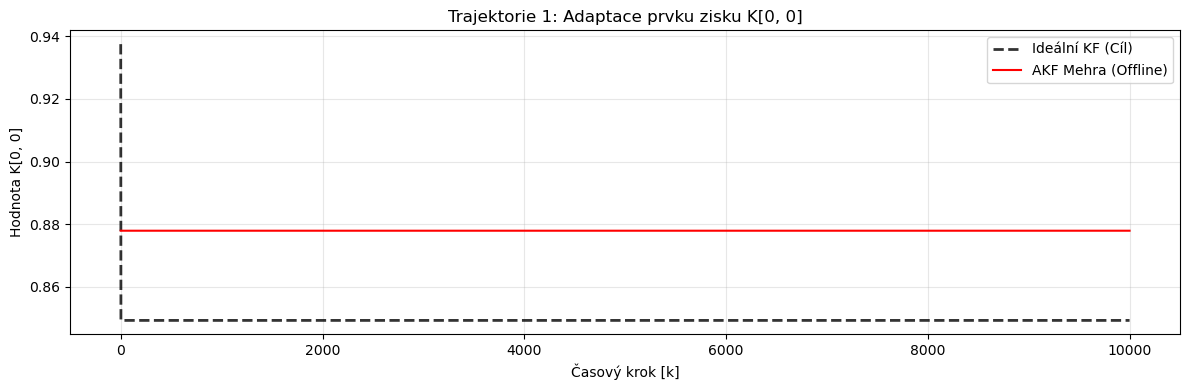

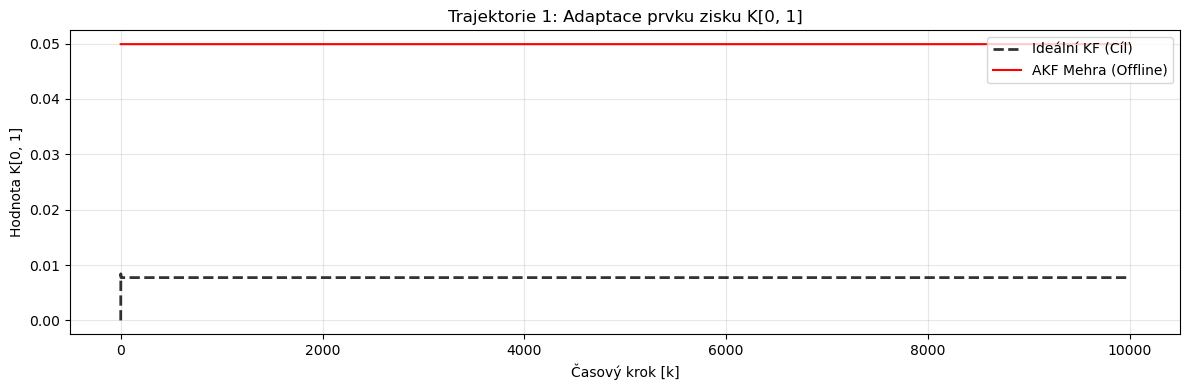

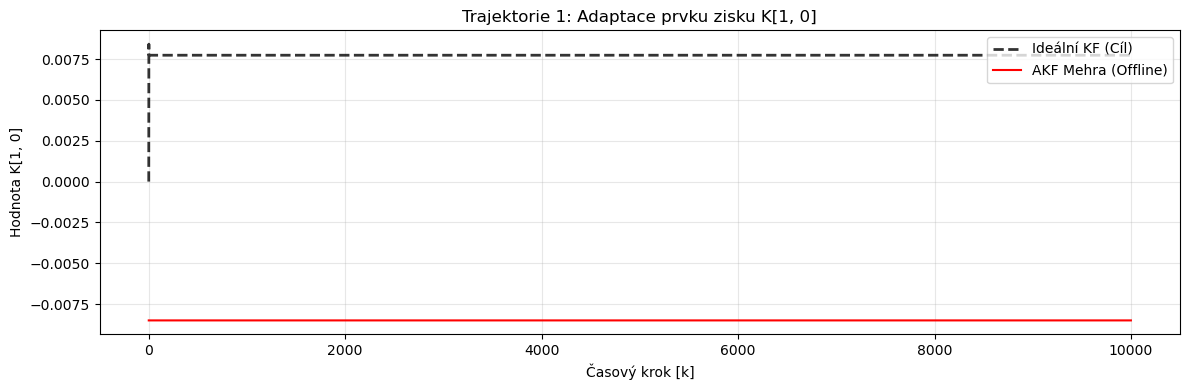

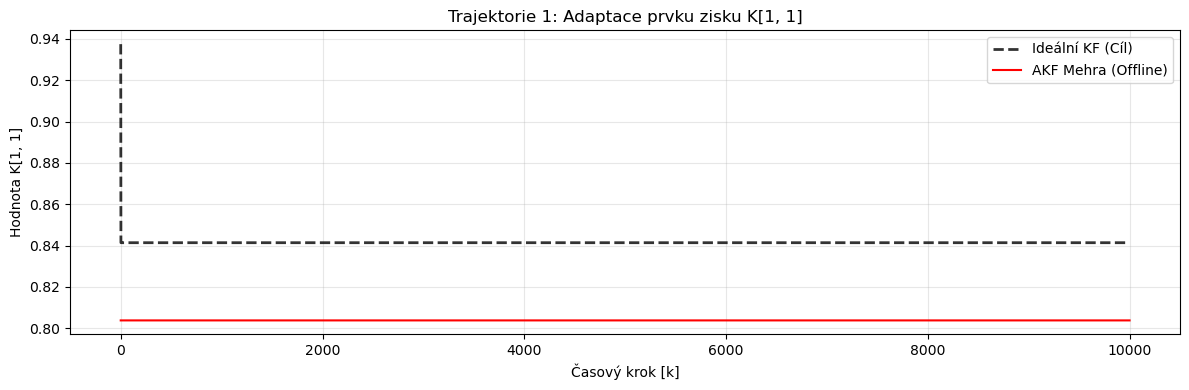

In [14]:
import matplotlib.pyplot as plt

# ==============================================================================
# ANALÝZA VÝVOJE KALMANOVA ZISKU (K) - VŠECHNY PRVKY
# ==============================================================================

num_plot_traj = min(3, NUM_TEST_TRAJ)
nx = sys_true.state_dim
nz = sys_true.obs_dim

# 1. Nejdříve si předpočítáme a uložíme výsledky, abychom nevolali filtry zbytečně vícekrát
print("Předpočítávám výsledky filtrů pro vykreslení...")
history_ideal = []
history_mehra = []

for i in range(num_plot_traj):
    y_test_gpu = y_test[i].to(device)
    
    # --- Ideální KF (Benchmark) ---
    res_ideal = kf_ideal.process_sequence(y_test_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
    history_ideal.append(res_ideal['Kalman_gain'].cpu())
    
    # --- AKF Mehra ---
    # [cite_start]Mehra odhaduje K přímo z inovací [cite: 1]
    mehra_res = akf_mehra_mismatched.process_sequence(y_test_gpu, Ex0=sys_model.Ex0, P0=sys_model.P0)
    history_mehra.append(mehra_res['Kalman_gain'].cpu())

# 2. Vykreslení - pro každý prvek matice K vytvoříme samostatný obrázek se subplots pro trajektorie
print("Generuji grafy pro jednotlivé prvky matice K...")

for row_idx in range(nx):
    for col_idx in range(nz):
        
        fig, axes = plt.subplots(num_plot_traj, 1, figsize=(12, 4 * num_plot_traj), sharex=True)
        if num_plot_traj == 1: axes = [axes]
        
        for i in range(num_plot_traj):
            ax = axes[i]
            
            # --- Ideální KF (Benchmark) ---
            k_ideal_val = history_ideal[i][:, row_idx, col_idx]
            ax.plot(k_ideal_val, 'k--', label='Ideální KF (Cíl)', alpha=0.8, linewidth=2)
            
            # --- AKF Mehra ---
            k_mehra_val = history_mehra[i][:, row_idx, col_idx]
            ax.plot(k_mehra_val, 'r-', label='AKF Mehra (Offline)', linewidth=1.5)
            
            # Prostor pro přidání tvého MDM/RLS filtru:
            # k_mdm_val = history_mdm[i][:, row_idx, col_idx]
            # ax.plot(k_mdm_val, 'b-', label='AKF (MDM/RLS)')

            ax.set_title(f"Trajektorie {i+1}: Adaptace prvku zisku K[{row_idx}, {col_idx}]")
            ax.set_ylabel(f"Hodnota K[{row_idx}, {col_idx}]")
            ax.grid(True, alpha=0.3)
            
            # Legendu stačí zobrazit jen v prvním podgrafu
            if i == 0:
                ax.legend(loc='upper right')

        axes[-1].set_xlabel("Časový krok [k]")
        plt.tight_layout()
        plt.show()

In [41]:
import torch
import numpy as np

from tqdm import tqdm

class KalmanFilter:
    def __init__(self,model):
        self.device = model.Q.device
        self.model = model
        self.Ex0 = model.Ex0
        self.P0 = model.P0
        self.F = model.F
        self.H = model.H
        self.Q = model.Q
        self.R = model.R
        self.state_dim = self.F.shape[0]
        self.obs_dim = self.H.shape[0]

        # Interní stav pro online použití
        self.x_predict_current = None
        self.P_predict_current = None
        self.reset(model.Ex0, model.P0)

    def reset(self, Ex0, P0):
        self.x_predict_current = Ex0.clone().detach().reshape(self.state_dim, 1)
        self.P_predict_current = P0.clone().detach()

    def predict_step(self, x_filtered, P_filtered):
        x_predict = self.F @ x_filtered
        P_predict = self.F @ P_filtered @ self.F.T + self.Q
        return x_predict, P_predict

    def update_step(self, x_predict, y_t, P_predict):
        y_t = y_t.reshape(self.obs_dim, 1)
        innovation = self.compute_innovation(y_t, x_predict)
        K = self.compute_kalman_gain(P_predict)
        x_filtered = x_predict + K @ innovation
        I = torch.eye(self.state_dim, device=self.device)
        P_filtered = (I - K @ self.H) @ P_predict @ (I - K @ self.H).T + K @ self.R @ K.T 
        return x_filtered, P_filtered, K, innovation

    def compute_kalman_gain(self, P_predict):
        return P_predict @ self.H.T @ torch.linalg.inv(self.H @ P_predict @ self.H.T + self.R)
    
    def compute_innovation(self, y_t, x_predict):
        return y_t - self.H @ x_predict
    
    def step(self, y_t):
        x_filtered, P_filtered, _, _ = self.update_step(self.x_predict_current, y_t, self.P_predict_current)
        x_predict_next, P_predict_next = self.predict_step(x_filtered, P_filtered)
        self.x_predict_current = x_predict_next
        self.P_predict_current = P_predict_next
        return x_filtered, P_filtered

    def process_sequence(self, y_seq, Ex0=None, P0=None):
            seq_len = y_seq.shape[0]
            x_filtered_history = torch.zeros(seq_len, self.state_dim, device=self.device)
            P_filtered_history = torch.zeros(seq_len, self.state_dim, self.state_dim, device=self.device)
            kalman_gain_history = torch.zeros(seq_len, self.state_dim, self.obs_dim, device=self.device)
            innovation_history = torch.zeros(seq_len, self.obs_dim, device=self.device)

            if Ex0 is None: Ex0 = self.Ex0
            if P0 is None: P0 = self.P0
            x_predict_k = Ex0.clone().detach().reshape(self.state_dim, 1)
            P_predict_k = P0.clone().detach()
            
            for k in range(seq_len):
                x_filtered, P_filtered, K, innovation = self.update_step(x_predict_k, y_seq[k], P_predict_k)
                x_predict_k_plus_1, P_predict_k_plus_1 = self.predict_step(x_filtered, P_filtered)
                x_predict_k = x_predict_k_plus_1
                P_predict_k = P_predict_k_plus_1
                x_filtered_history[k] = x_filtered.squeeze()
                P_filtered_history[k] = P_filtered
                kalman_gain_history[k] = K
                innovation_history[k] = innovation.squeeze()

            return {
                'x_filtered': x_filtered_history,
                'P_filtered': P_filtered_history,
                'Kalman_gain': kalman_gain_history,
                'innovation': innovation_history
            }

class AdaptiveKalmanFilter_mehra:
    def __init__(self, model, window_size=200):
        self.kf = KalmanFilter(model)
        self.model = model
        self.device = model.Q.device
        
        self.nx = self.kf.F.shape[0]
        self.nz = self.kf.H.shape[0]
        
        # Nastavení velikosti klouzavého okna (musí být větší než nx pro statistickou smysluplnost)
        self.window_size = window_size
        self.inov_buffer = []
        
        self.reset()

    def reset(self, Ex0=None, P0=None):
        """Vymaže buffery a zresetuje vnitřní stav před novou trajektorií."""
        if Ex0 is None: Ex0 = self.model.Ex0
        if P0 is None: P0 = self.model.P0
            
        self.kf.reset(Ex0, P0)
        self.x_predict = Ex0.clone().detach().reshape(self.nx, 1)
        self.inov_buffer = []
        
        # 1. Zvolme stabilní K lineárního filtru
        self.K = 0.5 * torch.linalg.pinv(self.kf.H)
    
    
    def step(self, y_t):
        y_t = y_t.reshape(self.nz, 1)
        
        # 1. Spočteme chybu před měřením (inovaci)
        inov = y_t - self.kf.H @ self.x_predict
        
        # Plnění klouzavého okna (bez mazání)
        self.inov_buffer.append(inov)
        if len(self.inov_buffer) > self.window_size:
            self.inov_buffer.pop(0)
            
        N_current = len(self.inov_buffer)
        
        # Výpočet matic proběhne, jakmile máme plné okno
        if N_current >= self.window_size:
            inov_tensor = torch.cat(self.inov_buffer, dim=1)
            
            # Odhad kovariancí pro l=0
            Py0 = (inov_tensor @ inov_tensor.T) / N_current
            
            Py_list = [Py0] 
            
            # Spočítáme \hat{P}_l^y podle rovnice (22)
            for l in range(1, self.nx + 1):
                inov_shift = inov_tensor[:, l:]
                inov_orig = inov_tensor[:, :-l]
                Py_l = (inov_shift @ inov_orig.T) / (N_current - l)
                Py_list.append(Py_l)
                
            G_list = []
            V_list = [] 
            
            F = self.kf.F
            H = self.kf.H
            K = self.K
            
            # Sestavíme G podle rovnice (21) a matici V podle (23)
            for l in range(1, self.nx + 1):
                # Matice G: G_l = H * F^l
                G_l = H @ torch.matrix_power(F, l)
                G_list.append(G_l)
                
                # Matice V (Rovnice 23): Každý řádek je součet
                V_l = Py_list[l].clone()
                for i in range(1, l + 1):
                    term = H @ torch.matrix_power(F, i) @ K @ Py_list[l - i]
                    V_l += term
                V_list.append(V_l)
                
            G = torch.cat(G_list, dim=0)
            V = torch.cat(V_list, dim=0)
            
            # Odhad součinu P^e * H^T podle rovnice (23)
            PHT = torch.linalg.pinv(G) @ V
            
            # Odhad Kalmanova zisku
            Py0_inv = torch.linalg.pinv(Py0 + 1e-6 * torch.eye(self.nz, device=self.device))
            K_est = PHT @ Py0_inv
            
            # KONTROLA STABILITY (jak jsi požadoval)
            A_test = F - F @ K_est @ H
            eigvals = torch.linalg.eigvals(A_test)
            max_eig = torch.max(torch.abs(eigvals))
            
            if max_eig >= 1.0:
                # Pokud je K_est nestabilní, nevypisujeme TypeError (nepoužíváme samotný return).
                # Výpočet raději pokračuje se starým stabilním K, nebo bys mohl vyvolat Exception.
                print(f"Varování: V iteraci se filtr stal nestabilním (max_eig={max_eig.item()}). K se nemění.")
            else:
                # Čistý přepis zisku - přesně jak diktuje vzorec bez tlumení
                self.K = K_est
            
        # Filtrace a predikce na další krok (rovnice lineárního filtru)
        x_filtered = self.x_predict + self.K @ inov
        self.x_predict = self.kf.F @ x_filtered
        
        # Metoda MUSÍ vrátit dvě proměnné pro process_sequence
        return x_filtered, self.K

    def process_sequence(self, y_seq, Ex0=None, P0=None):
        seq_len = y_seq.shape[0]
        
        # PŘIDÁNO: Reset před trajektorií
        self.reset(Ex0, P0)
        
        x_filtered_history = torch.zeros(seq_len, self.nx, device=self.device)
        P_filtered_history = torch.zeros(seq_len, self.nx, self.nx, device=self.device)
        kalman_gain_history = torch.zeros(seq_len, self.nx, self.nz, device=self.device)
        innovation_history = torch.zeros(seq_len, self.nz, device=self.device)
        
        for k in tqdm(range(seq_len), desc="Online filtrace s adaptivním K", leave=False):
            # Uložení inovace ještě před úpravou stavu
            z_t = y_seq[k].reshape(self.nz, 1)
            inov_k = z_t - self.kf.H @ self.x_predict
            
            x_filtered, K_current = self.step(y_seq[k])
            
            x_filtered_history[k] = x_filtered.squeeze()
            kalman_gain_history[k] = K_current
            innovation_history[k] = inov_k.squeeze()
            
        return {
            'x_filtered': x_filtered_history,
            'P_filtered': P_filtered_history,
            'Kalman_gain': kalman_gain_history,
            'innovation': innovation_history
        }


Generuji 1 testovacích trajektorií o délce 1000...
Generování dat dokončeno.

Vyhodnocuji modely...


Online filtrace s adaptivním K:  17%|█▋        | 173/1000 [00:00<00:00, 1714.01it/s]

Varování: V iteraci se filtr stal nestabilním (max_eig=1.2937889099121094). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3927617073059082). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3178541660308838). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1976149082183838). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1321756839752197). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0688703060150146). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1745444536209106). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.2531603574752808). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.216903805732727). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4249924421310425). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1815499067306519). K se nemění.
Varování: V iteraci se

Online filtrace s adaptivním K:  34%|███▍      | 345/1000 [00:00<00:00, 1026.58it/s]

Varování: V iteraci se filtr stal nestabilním (max_eig=1.672670602798462). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.6909854412078857). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.761847972869873). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.8237385749816895). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.832189679145813). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.9148272275924683). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.9254509210586548). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.922010898590088). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.9437192678451538). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.9465917348861694). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.9369035959243774). K se nemění.
Varování: V iteraci se fi

Online filtrace s adaptivním K:  56%|█████▌    | 559/1000 [00:00<00:00, 867.50it/s] 

Varování: V iteraci se filtr stal nestabilním (max_eig=1.004408597946167). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.003556728363037). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0216745138168335). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0095319747924805). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0947197675704956). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0943174362182617). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0939091444015503). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.098248839378357). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0816867351531982). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0857994556427002). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.06312894821167). K se nemění.
Varování: V iteraci se fil

Online filtrace s adaptivním K:  65%|██████▌   | 651/1000 [00:00<00:00, 770.97it/s]

Varování: V iteraci se filtr stal nestabilním (max_eig=1.4547014236450195). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4596482515335083). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4306554794311523). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4015138149261475). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3871171474456787). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3827846050262451). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3809305429458618). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3832247257232666). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3836734294891357). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.379927635192871). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3727649450302124). K se nemění.
Varování: V iteraci se

Online filtrace s adaptivním K:  81%|████████  | 809/1000 [00:00<00:00, 701.40it/s]

Varování: V iteraci se filtr stal nestabilním (max_eig=1.2250953912734985). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1789032220840454). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0766215324401855). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3774237632751465). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3752129077911377). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.370763897895813). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3656202554702759). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3574788570404053). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3509607315063477). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3452218770980835). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3372012376785278). K se nemění.
Varování: V iteraci se

Online filtrace s adaptivním K:  95%|█████████▌| 954/1000 [00:01<00:00, 687.92it/s]

Varování: V iteraci se filtr stal nestabilním (max_eig=1.2999241352081299). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.2473098039627075). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.2214299440383911). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1974233388900757). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1704919338226318). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1621019840240479). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1536675691604614). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.1276190280914307). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.102038025856018). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0892387628555298). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.068949818611145). K se nemění.
Varování: V iteraci se 

Varování: V iteraci se filtr stal nestabilním (max_eig=1.0352357625961304). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.0003089904785156). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4032607078552246). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4876700639724731). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.5473461151123047). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.5433183908462524). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.4995741844177246). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.5367525815963745). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.3885433673858643). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.308449149131775). K se nemění.
Varování: V iteraci se filtr stal nestabilním (max_eig=1.260728120803833). K se nemění.
Varování: V iteraci se 

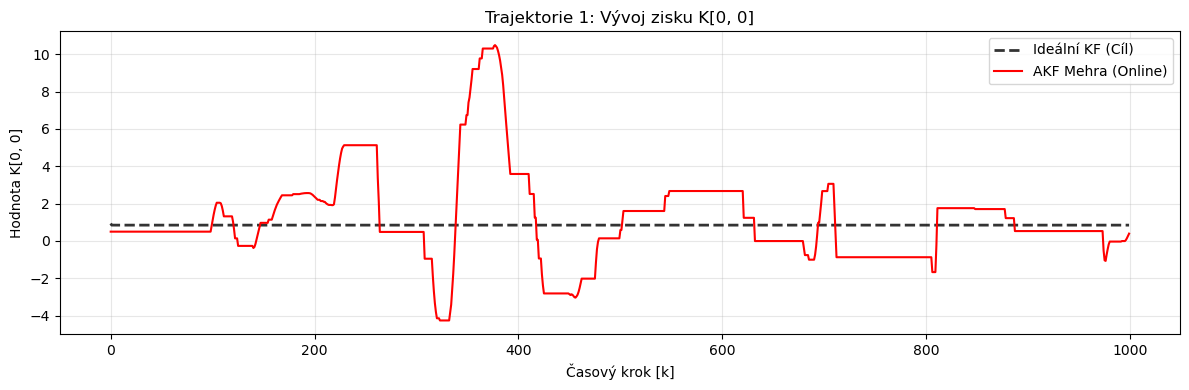

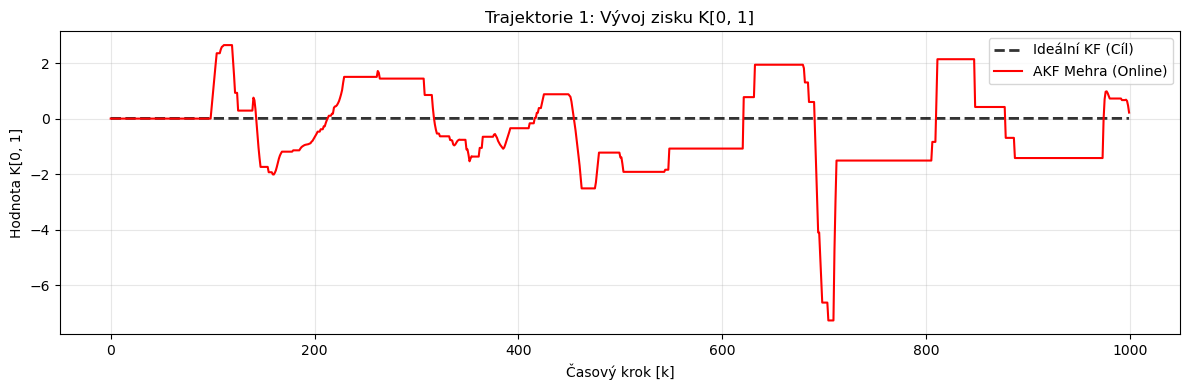

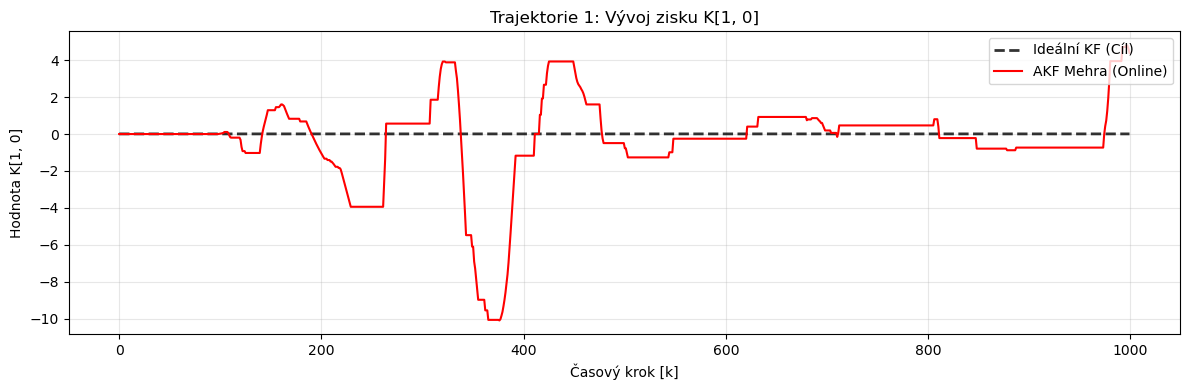

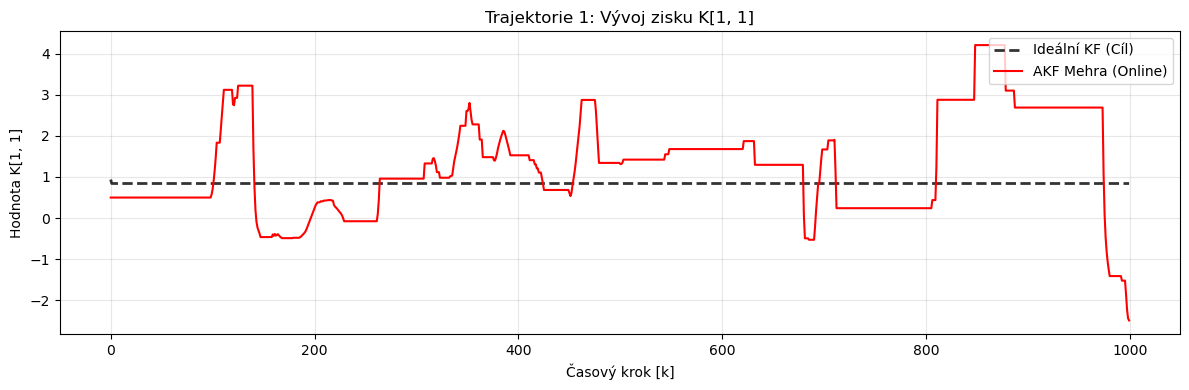

In [43]:
# ==============================================================================
# 1. KONFIGURACE TESTU A PŘÍPRAVA DAT
# ==============================================================================
TEST_SEQ_LEN = 1000
NUM_TEST_TRAJ = 1

print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

# ==============================================================================
# 2. INICIALIZACE FILTRŮ A VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# Budeme testovat pouze Ideální KF (cíl) a Online AKF (nepřesný model)
kf_ideal = Filters.KalmanFilter(sys_true)
akf_mehra_online = AdaptiveKalmanFilter_mehra(sys_true, window_size=100)

all_x_true_cpu = []
all_x_hat_kf_ideal_cpu = []
all_x_hat_akf_mehra_cpu = []

history_K_ideal = []
history_K_mehra = []

print(f"\nVyhodnocuji modely...")
with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        
        # --- Ideální KF ---
        kf_i_res = kf_ideal.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        all_x_hat_kf_ideal_cpu.append(kf_i_res['x_filtered'].cpu())
        history_K_ideal.append(kf_i_res['Kalman_gain'].cpu())
        
        # --- Online AKF Mehra ---
        mehra_res = akf_mehra_online.process_sequence(y_test_seq_gpu, Ex0=sys_true.Ex0, P0=sys_true.P0)
        all_x_hat_akf_mehra_cpu.append(mehra_res['x_filtered'].cpu())
        history_K_mehra.append(mehra_res['Kalman_gain'].cpu())

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        print(f"Trajektorie {i + 1}/{NUM_TEST_TRAJ} zpracována.")


# Výpočet průměrného MSE
mse_kf_ideal = []
mse_akf_mehra = []

for i in range(NUM_TEST_TRAJ):
    x_true = all_x_true_cpu[i]
    mse_kf_ideal.append(F.mse_loss(all_x_hat_kf_ideal_cpu[i][1:], x_true[1:]).item())
    mse_akf_mehra.append(F.mse_loss(all_x_hat_akf_mehra_cpu[i][1:], x_true[1:]).item())

print("\n" + "="*60)
print("FINÁLNÍ VÝSLEDKY (MSE)")
print("="*60)
print(f"Ideální KF:          {np.mean(mse_kf_ideal):.4f}")
print(f"Online AKF (Mehra):  {np.mean(mse_akf_mehra):.4f}")
print("="*60)


# ==============================================================================
# 3. VYKRESLENÍ VÝVOJE MATICE K
# ==============================================================================
print("\nGeneruji grafy vývoje zisku K...")

nx = sys_true.state_dim
nz = sys_true.obs_dim
num_plot_traj = min(3, NUM_TEST_TRAJ)

for row_idx in range(nx):
    for col_idx in range(nz):
        
        fig, axes = plt.subplots(num_plot_traj, 1, figsize=(12, 4 * num_plot_traj), sharex=True)
        if num_plot_traj == 1: axes = [axes]
        
        for i in range(num_plot_traj):
            ax = axes[i]
            
            # Hodnoty z ideálního filtru (konstantní benchmark)
            k_ideal_val = history_K_ideal[i][:, row_idx, col_idx]
            ax.plot(k_ideal_val, 'k--', label='Ideální KF (Cíl)', alpha=0.8, linewidth=2)
            
            # Hodnoty z online adaptivního filtru
            k_mehra_val = history_K_mehra[i][:, row_idx, col_idx]
            ax.plot(k_mehra_val, 'r-', label='AKF Mehra (Online)', linewidth=1.5)

            ax.set_title(f"Trajektorie {i+1}: Vývoj zisku K[{row_idx}, {col_idx}]")
            ax.set_ylabel(f"Hodnota K[{row_idx}, {col_idx}]")
            ax.grid(True, alpha=0.3)
            
            if i == 0:
                ax.legend(loc='upper right')

        axes[-1].set_xlabel("Časový krok [k]")
        plt.tight_layout()
        plt.show()